In [92]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error


In [93]:
#read census data into pandas dataframe selecting only relevant columns
census_2011 = pd.read_csv('./2011-india-census/india-districts-census-2011.csv', usecols=list(range(1,9)) + list(range(25,26)) +  list(range(35,40)) + list(range(68,70)) + list(range(117,118)))

In [94]:
'''
Create new columns representing potentially useful features for regression algorithm
New Columns:
Percentage of Owned Households per district
Male to Female Ratio per district
Total Literacy Rate per district
Percentage of Urban Households per district
Percentage of Households with Internet per district
Percentage of Hindus per district

'''

census_2011['Percentage of Owned Households'] = census_2011['Ownership_Owned_Households']/census_2011['Households']
census_2011['Male to Female Ratio'] = census_2011['Male']/census_2011['Female']
census_2011['Total Literacy Rate'] = census_2011['Literate']/census_2011['Population']
census_2011['Percentage of Urban Households'] = census_2011['Urban_Households']/census_2011['Households']
census_2011['Percentage of Households with Internet'] = census_2011['Households_with_Internet']/census_2011['Households']
census_2011['Percentage Hindu'] = census_2011['Hindus']/census_2011['Population']


In [47]:
#Create a categorical variable representing the percentage of hindus in each district in India

bins = [0, .33, .66, 1]
census_2011['Binned Hindu'] = pd.cut(census_2011['Percentage Hindu'], bins)
hindus = pd.get_dummies(census_2011['Binned Hindu'], drop_first=True)
census_2011 = pd.concat([census_2011, hindus], axis=1)

In [48]:
#Create a categorical variable representing the percentage of owned households in each district in India


av = np.average(census_2011['Percentage of Owned Households'], weights = census_2011['Population'])
bins_av = [0,av,1]
census_2011['Binned Ownership'] = pd.cut(census_2011['Percentage of Owned Households'], bins_av)
ownership = pd.get_dummies(census_2011['Binned Ownership'],drop_first=True)
census_2011 = pd.concat([census_2011,ownership], axis = 1)

In [49]:
#Drop categorical variable columns 

census_2011=census_2011.drop(columns=['Binned Ownership', 'Binned Hindu', 'Percentage Hindu'])

In [50]:
#select only relevant columns (purchase power parity, literacy rate, male to female ratio, percentage of urban households, percentage of households with computers)
data = census_2011.iloc[:, -10:]
# data = pd.DataFrame(census_2011['Percentage of Owned Households'])
# separate y target 
target = census_2011['Total Literacy Rate']
# drop target leaving only features to build model on
features = data.drop(columns=['Total Literacy Rate'])
# features = data

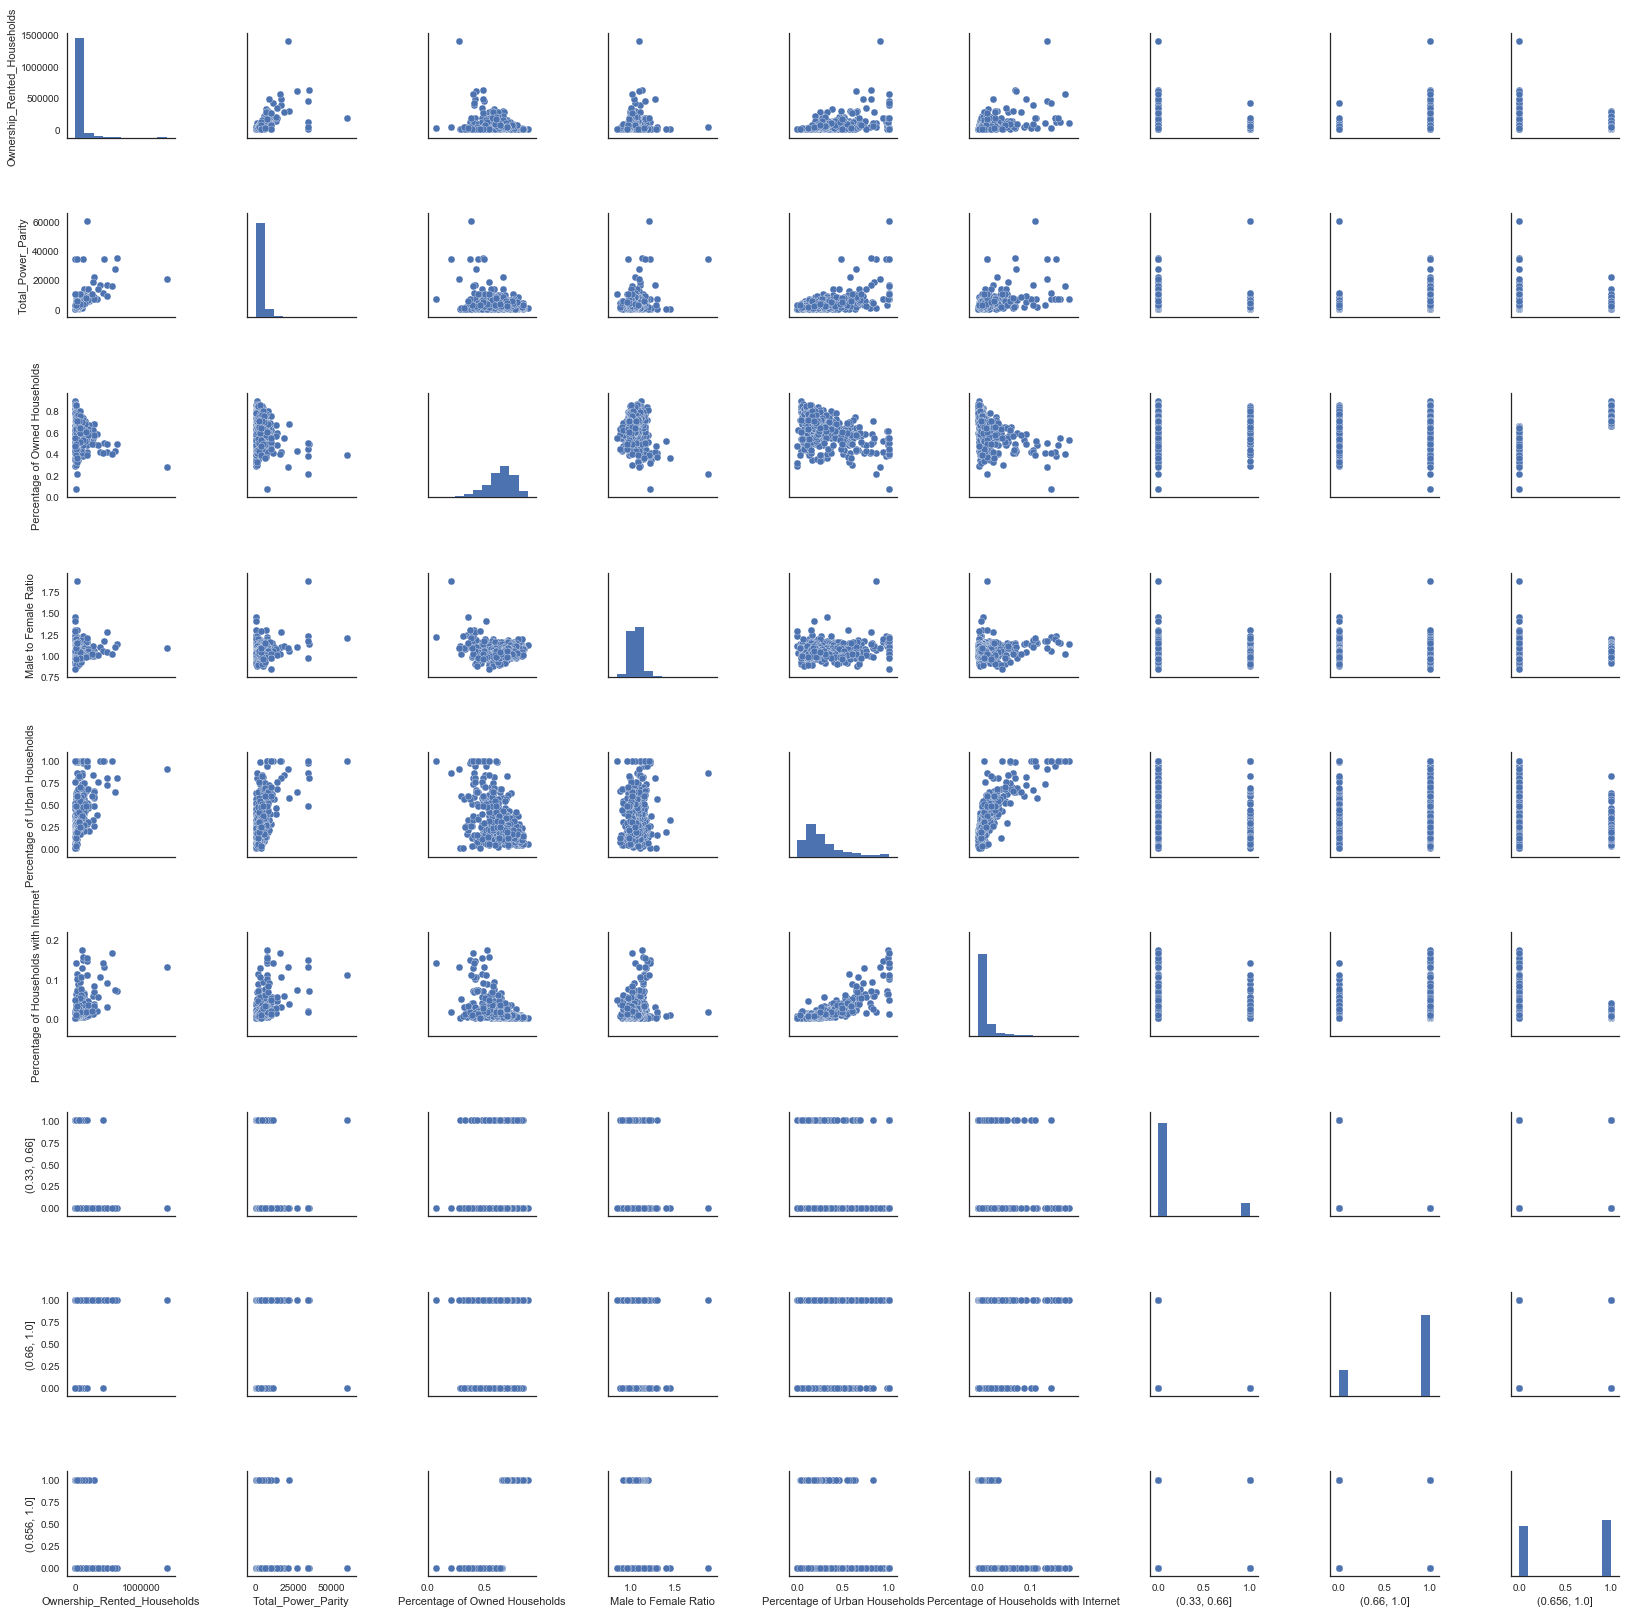

In [51]:
sns.pairplot(features)

In [52]:
#split training and test data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [53]:
#initialize Linear Regression model 
lr = linear_model.LinearRegression()

In [54]:
#fit data to model
model = lr.fit(X_train, y_train)

In [55]:
#run test data through Model and test outputs equal to y_pred
y_pred = model.predict(X_test)


In [56]:
#model score (R^2)
r2 = model.score(X_test, y_test)
ar2 = 1 - (1-model.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

In [57]:
print(r2, ar2)

0.544041188955985 0.509264669469577


Text(0,0.5,'Predictions')

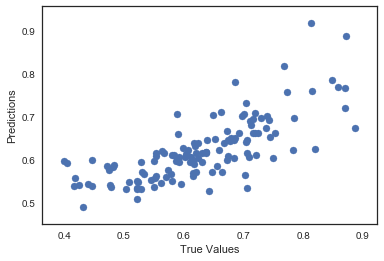

In [58]:
#residual plot
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")

array([-1.13726586e-07,  2.14819424e-06, -2.86440874e-01, -3.31558182e-01,
        1.82565392e-01,  2.25439637e-01,  2.63488504e-02,  2.37115864e-02,
       -3.51432225e-03])

In [88]:
kfold5 = KFold(n_splits=5, shuffle=True, random_state=42)
kfold10 = KFold(n_splits=10, shuffle=True, random_state=42)
kfold20 = KFold(n_splits=20, shuffle=True, random_state=42)

In [90]:
#Initial cross validation scores for basic linear regression model
cv_5_results = np.mean((cross_val_score(model, features, target, cv=kfold5)))
cv_10_results = np.mean((cross_val_score(model, features, target, cv=kfold10)))
cv_20_results = np.mean((cross_val_score(model, features, target, cv=kfold20)))

In [91]:
print(cv_5_results, cv_10_results, cv_20_results)

0.4203413889093898 0.4116335275178852 0.3904869380328132


In [20]:
#Import preprocessing to scale data for feature engineering

from sklearn import preprocessing
from sklearn import pipeline
scaler = preprocessing.StandardScaler()

In [21]:
#Scale the numerical variables in our dataframe and create our training data set for features

scaler.fit(X_train.iloc[:,:-3])
features_scaled_train = pd.DataFrame(scaler.transform(X_train.iloc[:,:-3]), columns = X_train.columns[:-3], index = X_train.index)
cat_variables = X_train.iloc[:, -3:]
features_scaled_train = pd.concat([features_scaled_train, cat_variables], axis=1)

In [22]:
#Scale the numerical variables in our dataframe and create our testing data set for features

scaler.fit(X_test.iloc[:,:-3])
features_scaled_test = pd.DataFrame(scaler.transform(X_test.iloc[:,:-3]), columns = X_test.columns[:-3], index = X_test.index)
cat_variables_test = X_test.iloc[:, -3:]
features_scaled_test = pd.concat([features_scaled_test, cat_variables_test], axis=1)

In [23]:
#Renaming the columns of our categorical variables 

features_scaled_train.rename(columns={features_scaled_train.columns[6]: 'HINDUS ZERO TO 33%', features_scaled_train.columns[7]: 'HINDUS 66% TO 100%', features_scaled_train.columns[8]:'OWNERSHIP OF HOUSEHOLDS > MEAN' 
                               
                               }, inplace=True)

features_scaled_test.rename(columns={features_scaled_test.columns[6]: 'HINDUS ZERO TO 33%', features_scaled_test.columns[7]: 'HINDUS 66% TO 100%', features_scaled_test.columns[8]:'OWNERSHIP OF HOUSEHOLDS > MEAN' 
                               
                               }, inplace=True)

In [24]:
#Using Polynomial Features to transform our dataframe and get more features

poly = preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
features_interactions_train = pd.DataFrame(poly.fit_transform(features_scaled_train), columns=poly.get_feature_names(features_scaled_train.columns))
features_interactions_test = pd.DataFrame(poly.fit_transform(features_scaled_test), columns=poly.get_feature_names(features_scaled_test.columns))

In [25]:
#Begin feature engineering by removing features that have a low variance

from sklearn.feature_selection import VarianceThreshold

In [26]:
thresholder = VarianceThreshold(threshold=.5)

In [27]:
def variance_threshold_selector(data, threshold = .5): 
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [28]:
#Dropping features that have a low variance

features_selected_train = variance_threshold_selector(features_interactions_train)

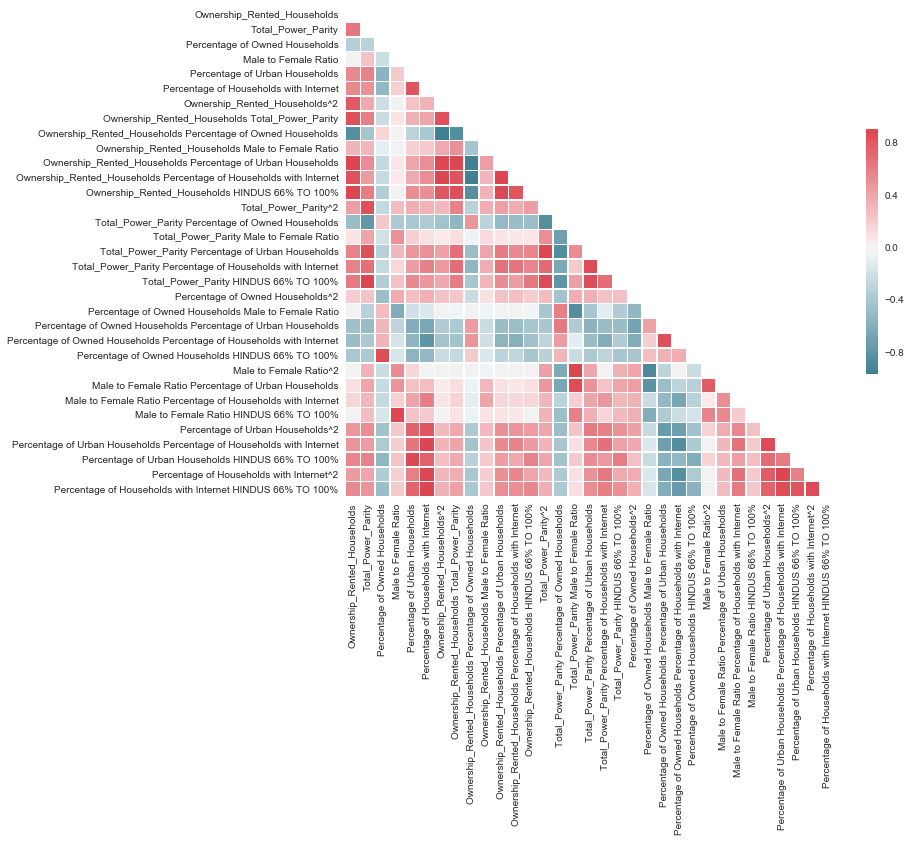

In [29]:
#Creating a heatmap to show features that are highly correlated

sns.set(style = 'white')

corr = features_selected_train.corr()

mask = np.zeros_like(corr,dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (11,9))

cmap = sns.diverging_palette(220,10,as_cmap=True)

sns.heatmap(corr,mask=mask,cmap=cmap,vmax=0.9,center=0,square=True,linewidths=0.5,cbar_kws={'shrink' : 0.5})

In [30]:
#Creating a correlation matrix

corr_matrix = features_selected_train.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))

#Creating a list of columns to drop
to_drop = [column for column in upper.columns if any(upper[column]>0.95)]

In [31]:
#Drop certain highly correlated features
features_selected_train.drop(columns=to_drop,inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [32]:
#Creating Linear Regression model for data post initial feature engineering
model = lr.fit(features_selected_train, y_train)

In [33]:
#Calculating predicted y values
features_selected_test = features_interactions_test[features_selected_train.columns]
y_pred = model.predict(features_selected_test)

In [34]:
#Calculating r^2 post initial feature engineering

r2 = model.score(features_selected_train, y_train)
r2

0.5009777090791412

In [35]:
#Calculating cross-validation scores post initial feature engineering

cv_5_results = np.mean((cross_val_score(model, features_selected_train, y_train, cv=5)))
cv_10_results = np.mean((cross_val_score(model, features_selected_train, y_train, cv=10)))
cv_20_results = np.mean((cross_val_score(model, features_selected_train, y_train, cv=20)))

In [36]:
print(cv_5_results, cv_10_results, cv_20_results)

-0.021648555291510864 -0.48179170151879 -0.6645697649276893
